In [1]:
import glob
import Colors
import glob
import Colors
from scipy.cluster.hierarchy import dendrogram, linkage
from neupy import algorithms
from scipy.stats.stats import pearsonr   
from scipy.interpolate import interp1d
import itertools as it

In [2]:
def zscore(df):
    df = df.loc[df.index[df.sum(axis=1)>0]]
    zdf = df.T
    zdf = (zdf-zdf.mean())/zdf.std()
    zdf = zdf.T
    return zdf

def scalezscore(zdf):
    df  = ((zdf.T>=0)*zdf.T/zdf.max(axis=1) + (zdf.T<0)*zdf.T/abs(zdf.min(axis=1))).T
    return df

# read Carnegie data

In [3]:
dfS1 = pd.read_excel('/Users/anna/Dropbox/gastruloids/data/human_organogenesis_GSE18887/TableS1.xls', sheetname='Table S1', skiprows=[0])
dfS2 = pd.read_excel('/Users/anna/Dropbox/gastruloids/data/human_organogenesis_GSE18887/TableS2.xls', sheetname='Table S2', skiprows=[0])

In [4]:
samples = [idx for idx in dfS1.columns if 'S' in idx and '_' in idx and '.' not in idx]

In [5]:
dfS1.shape, dfS2.shape

((5441, 46), (2148, 26))

In [6]:
dfS1 = dfS1.set_index('AffyID')
dfS2 = dfS2.set_index('AffyID')

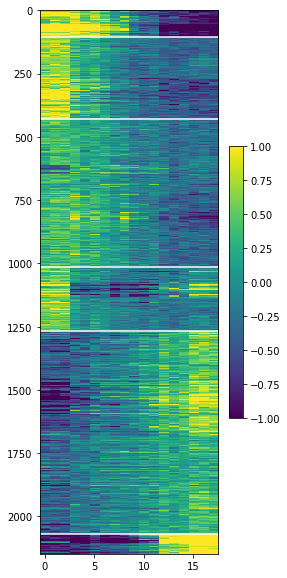

In [7]:
plt.figure(figsize=(4,10))
plt.imshow(dfS2.loc[dfS2.sort_values(by='Clusters 1-6', ascending=True).index, samples], aspect = 'auto', vmin = -1, vmax = 1)
plt.axhline((dfS2['Clusters 1-6']==1).sum(), c = 'w')
plt.axhline((dfS2['Clusters 1-6']<=2).sum(), c = 'w')
plt.axhline((dfS2['Clusters 1-6']<=3).sum(), c = 'w')
plt.axhline((dfS2['Clusters 1-6']<=4).sum(), c = 'w')
plt.axhline((dfS2['Clusters 1-6']<=5).sum(), c = 'w')
plt.colorbar(shrink = 0.5)
plt.show()

In [8]:
expdfS1 = dfS1[['Symbol']+samples]
expdfS1 = expdfS1.groupby('Symbol').aggregate(sum)
nexpdfS1 = expdfS1.sum().median()*expdfS1/expdfS1.sum()

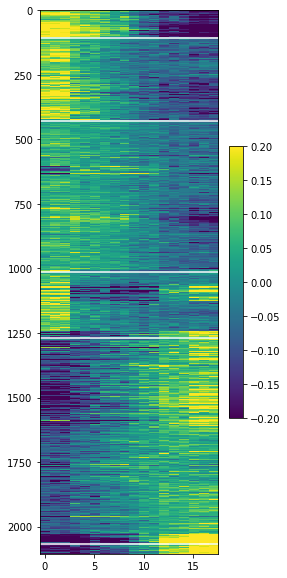

In [9]:
idxs = dfS2.sort_values(by='Clusters 1-6', ascending=True)['Symbol'].values
idxs = [g for g in idxs if g in nexpdfS1.index]
plt.figure(figsize=(4,10))
plt.imshow(np.log2(nexpdfS1.T/nexpdfS1.T.mean()).T.loc[idxs, samples], aspect = 'auto', vmin = -0.2, vmax = 0.2)
plt.axhline((dfS2['Clusters 1-6']==1).sum(), c = 'w')
plt.axhline((dfS2['Clusters 1-6']<=2).sum(), c = 'w')
plt.axhline((dfS2['Clusters 1-6']<=3).sum(), c = 'w')
plt.axhline((dfS2['Clusters 1-6']<=4).sum(), c = 'w')
plt.axhline((dfS2['Clusters 1-6']<=5).sum(), c = 'w')
plt.colorbar(shrink = 0.5)
plt.show()

In [10]:
znexpdfS1 = zscore(nexpdfS1)

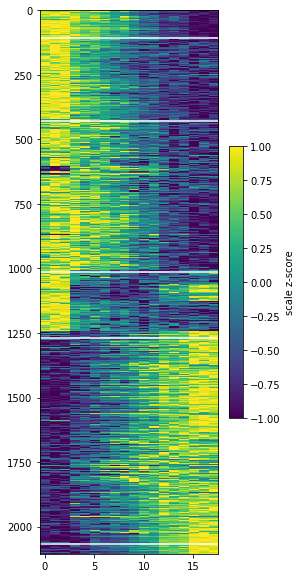

In [11]:
idxs = dfS2.sort_values(by='Clusters 1-6', ascending=True)['Symbol'].values
idxs = [g for g in idxs if g in nexpdfS1.index]
plt.figure(figsize=(4,10))
plt.imshow(scalezscore(znexpdfS1.loc[idxs]), aspect = 'auto')
plt.axhline((dfS2['Clusters 1-6']==1).sum(), c = 'w')
plt.axhline((dfS2['Clusters 1-6']<=2).sum(), c = 'w')
plt.axhline((dfS2['Clusters 1-6']<=3).sum(), c = 'w')
plt.axhline((dfS2['Clusters 1-6']<=4).sum(), c = 'w')
plt.axhline((dfS2['Clusters 1-6']<=5).sum(), c = 'w')
plt.colorbar(shrink = 0.5, label = 'scale z-score')
plt.show()

# read Human Chi data

In [13]:
def removeGenes(df):
    genes = ['ERCC', 'Kcnq1ot1', 'Mir5109', 'Lars2','Malat1', 'Rn45s', 'RPL', 'RPS','__MT']
    exclude = [idx for idx in df.index for g in genes if g in idx]
    return df.loc[[idx for idx in df.index if idx not in exclude]]

def removeGmGenes(df):
    alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    numbers = [str(i) for i in range(10)]
    gmhumangenes = []
    for idx in df.index:
        g = idx.rsplit('_')[1]
        if all([x in alphabet for x in g[:2]]) and all([x in numbers for x in g[2:-2]]) and g[-2]=='.' and g[-1] in numbers:
            gmhumangenes.append(idx)
    return df.loc[[idx for idx in df.index if idx not in gmhumangenes]]

def removePeakyGenes(df):
    genes = []
    for idx in df.index:
        if sum(df.loc[idx]/df.loc[idx].sum()>=0.9)>=1: # and df.loc[idx].sum()<20:
            genes.append(idx)
    return df.loc[[idx for idx in df.index if idx not in genes]] # genes

def renameIdxs(df):
    newnames = []
    for idx in df.index:
        if len(idx.rsplit('_'))>=2:
            newnames.append(idx.rsplit('_')[1])
        else:
            newnames.append(idx)
    return newnames

In [14]:
files = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figHuman/heatmap_average_Chi.txt'
zavdf = read_csv(files, sep = '\t', index_col=0)

In [15]:
zavdf.index = renameIdxs(zavdf)

In [16]:
files = glob.glob('/Users/anna/Dropbox/gastruloids/data/hGstl-tomo/*-Chi/*trim_star_spliced.coutt.tsv')

In [17]:
hdfs = [read_csv(f, sep = '\t', index_col = 0) for f in files]

In [18]:
fhdfs = [removePeakyGenes(removeGmGenes(removeGenes(df))) for df in hdfs]

In [19]:
nfhdfs = [df.sum().mean()*df/df.sum() for df in fhdfs]

In [20]:
nfhdfs[0].index = renameIdxs(nfhdfs[0])
nfhdfs[1].index = renameIdxs(nfhdfs[1])
nfhdfs[0]['GENEID'] = nfhdfs[0].index
nfhdfs[1]['GENEID'] = nfhdfs[1].index
nfhdfs[0] = nfhdfs[0].groupby('GENEID').aggregate(sum)
nfhdfs[1] = nfhdfs[1].groupby('GENEID').aggregate(sum)

In [21]:
genefile = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figHuman/som_hcl_Chi.txt'
genes_gastruloids = read_csv(genefile, sep = '\t', index_col=0)

In [22]:
genes_gastruloids.index = renameIdxs(genes_gastruloids)

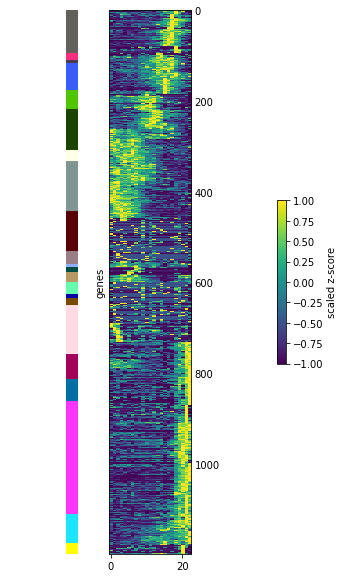

In [24]:
plt.figure(figsize=(5,10))

gene_order = genes_gastruloids.sort_values(by=['hcl','som']).index

plt.subplot(1,3,1, frameon = False)
y0 = 0; z0 = 0
for i in set(genes_gastruloids['hcl']):
    y = 1.0*genes_gastruloids[genes_gastruloids['hcl'] == i].shape[0]/genes_gastruloids.shape[0]
    plt.bar([3.5], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y  

plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2,4)

plt.subplot(1,3,2)
plt.imshow(scalezscore(zavdf.loc[gene_order[::-1]]), aspect='auto')
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.ylabel('genes')

plt.subplot(1,3,3, frameon = False)
plt.colorbar(label = 'scaled z-score', shrink = 0.3)
plt.xticks([])
plt.yticks([])

plt.show()

# comparison

In [25]:
commonGenes = genes_gastruloids.loc[[x for x in genes_gastruloids.index if x in list(dfS2['Symbol'])]].copy()

In [26]:
commonGenes['invivo'] = [dfS2[dfS2['Symbol']==x]['Clusters 1-6'].values.mean() for x in commonGenes.index]

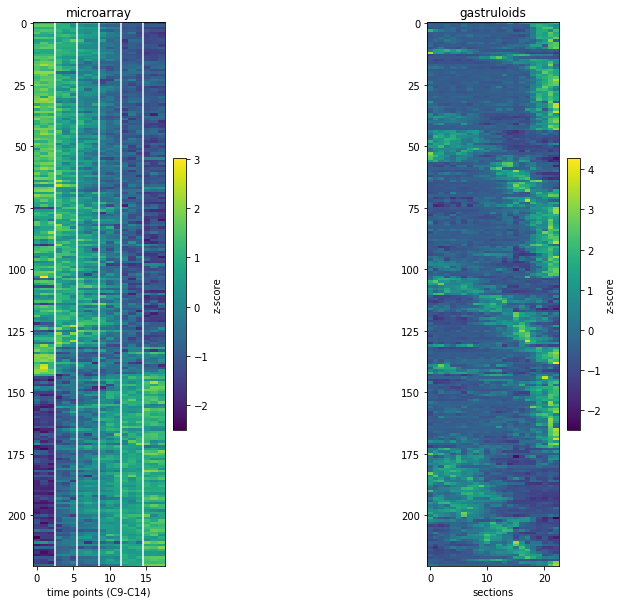

In [40]:
gene_order = [x for x in commonGenes.sort_values(['invivo','hcl','som']).index if x in znexpdfS1.index]

plt.figure(figsize=(10,10))

plt.subplot(131)
plt.imshow(znexpdfS1.loc[gene_order], aspect = 'auto')
plt.colorbar(shrink = 0.5, label = 'z-score')
plt.title('microarray')
plt.xlabel('time points (C9-C14)')
plt.axvline(2.5,c = 'w')
plt.axvline(5.5,c = 'w')
plt.axvline(8.5,c = 'w')
plt.axvline(11.5,c = 'w')
plt.axvline(14.5,c = 'w')

plt.subplot(133)
plt.imshow(zavdf.loc[gene_order], aspect = 'auto')
plt.colorbar(shrink = 0.5, label = 'z-score')
plt.title('gastruloids')
plt.xlabel('sections')

plt.savefig('heatmaps-zscore-microarray-avhgst.pdf', bbox_inches = 'tight')

plt.show()

# pool expression values (total)

In [30]:
# pool gastruloid expression
pnfhdfs = pd.DataFrame(nfhdfs[0].sum(axis=1)).merge(pd.DataFrame(nfhdfs[1].sum(axis=1)), how = 'inner', left_index = True, right_index = True)
pnfhdfs.columns = ['hG01','hG02']

In [31]:
mdf = nexpdfS1.merge(pnfhdfs, how = 'inner', left_index=True, right_index=True)

In [42]:
nmdf = 1e6*mdf/mdf.sum()
zmdf = zscore(nmdf)

In [43]:
genes_comon = genes_gastruloids.loc[[x for x in genes_gastruloids.index if x in zmdf.index]]

In [61]:
def SOMclustering(df, gridheight = 10, gridwidth = 10, seed = 54321):
    np.random.seed = seed
    GRID_HEIGHT = gridheight
    GRID_WIDTH = gridwidth
    somfun = algorithms.SOFM(
            n_inputs=len(df.columns),
            features_grid=(GRID_HEIGHT, GRID_WIDTH),
            learning_radius=4,
            reduce_radius_after=50,
            step=0.5,
            std=1,
            shuffle_data=True,
            verbose=False)
    somfun.train(np.array(df), epochs = 300)
    clustersr = somfun.predict(np.array(df)).argmax(axis=1)
    cl_genelist_df = pd.Series(clustersr, index = df.index)
    return cl_genelist_df

def hierarchicalClustering(df, cth = 100, plot = False, method = 'ward', metric = 'euclidean', nolabels = 'True'):
    Z = linkage(df, method=method, metric = metric)
    dg = dendrogram(Z, no_labels=nolabels, color_threshold=cth, no_plot = np.invert(plot))
    plt.show()
    return Z, dg

def getClusterByColor(dg, labels):
    kk = []
    ii = 0
    cluster = 0
    color = dg['color_list'][0]
    clusters = {cluster: []}
    for i in range(len(dg['icoord'])):
        v = dg['icoord'][i]
        for j in [0,2]:
            vj = int(round((v[j]-5.)/10))
            if (v[j]-5.)/10 == vj and vj not in kk:
                kk.append(vj)
                if dg['color_list'][i] == color:
                    clusters[cluster].append(labels[dg['leaves'][vj]])
                else:
                    color = dg['color_list'][i]
                    cluster += 1
                    clusters[cluster] = [labels[dg['leaves'][vj]]]
    return clusters

def comboCluster(df, genes, gridheight = 10, gridwidth = 10, cth = 100, plot = True, method = 'ward', metric = 'euclidean', seed = 12345, nolabels = 'True'):
    somcl = SOMclustering(df.loc[genes], gridheight = gridheight, gridwidth = gridwidth, seed = seed)
    mdf_som = pd.DataFrame({i: df.loc[somcl[somcl==i].index].mean() for i in set(somcl) })
    Z, dg = hierarchicalClustering(mdf_som.T, cth = cth, plot = plot, method = method, metric = metric, nolabels = nolabels)
    if plot:
        plt.show()
    ghcl = getClusterByColor(dg, list(mdf_som.columns))
    cl_df = pd.DataFrame(somcl, columns = ['som'])
    cl_df['hcl'] = [k for s in cl_df['som'] for k in ghcl.keys() if s in ghcl[k]]
    return cl_df

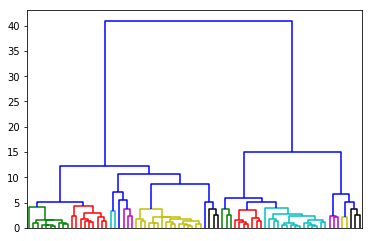

In [64]:
clGenes = comboCluster(zmdf.loc[genes_comon.index], genes_comon.index, gridheight=9, gridwidth=9, cth = 5)

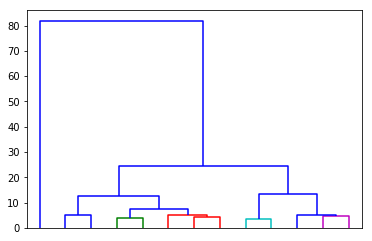

In [67]:
clSample = comboCluster(zmdf.loc[genes_comon.index].T, zmdf.columns, gridheight=5, gridwidth=4, cth = 5)

In [52]:
clSample

NameError: name 'clSample' is not defined

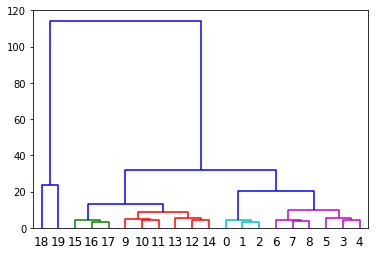

In [49]:
Zsamples, dgsamples = hierarchicalClustering(zmdf.loc[genes_comon.index].T, cth = 10, plot = True, method = 'ward', metric = 'euclidean', nolabels=False)

In [50]:
zmdf.columns

Index([ u'S9_R1',  u'S9_R2',  u'S9_R3', u'S10_R1', u'S10_R2', u'S10_R3',
       u'S11_R1', u'S11_R2', u'S11_R3', u'S12_R1', u'S12_R2', u'S12_R3',
       u'S13_R1', u'S13_R2', u'S13_R3', u'S14_R1', u'S14_R2', u'S14_R3',
         u'hG01',   u'hG02'],
      dtype='object')

# pool expression values (only common genes)

In [53]:
# pool gastruloid expression
pnfhdfs = pd.DataFrame(nfhdfs[0].sum(axis=1)).merge(pd.DataFrame(nfhdfs[1].sum(axis=1)), how = 'inner', left_index = True, right_index = True)
pnfhdfs.columns = ['hG01','hG02']

mdf = nexpdfS1.merge(pnfhdfs, how = 'inner', left_index=True, right_index=True)

In [54]:
genes_comon = genes_gastruloids.loc[[x for x in genes_gastruloids.index if x in mdf.index]]

In [56]:
fmdf = mdf.loc[genes_comon.index]

In [58]:
nfmdf = 1e6*fmdf/fmdf.sum()
zfmdf = zscore(nfmdf)

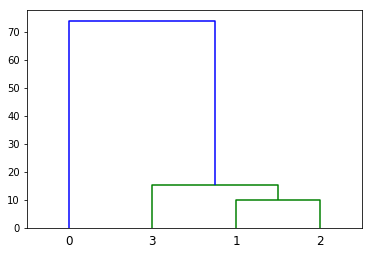

In [73]:
#clGenes = comboCluster(zfmdf.loc[genes_comon.index], genes_comon.index, gridheight=9, gridwidth=9, cth = 5)
clSample = comboCluster(zfmdf.loc[genes_comon.index].T, zfmdf.columns, gridheight=3, gridwidth=2, cth = 20, nolabels=False)

In [70]:
len(zfmdf.columns)

20

In [74]:
clSample

,som,hcl
S9_R1,5,0
S9_R2,5,0
S9_R3,5,0
S10_R1,4,0
S10_R2,4,0
S10_R3,4,0
S11_R1,4,0
S11_R2,4,0
S11_R3,4,0
S12_R1,4,0


# z-score based on microarray data

In [171]:
nexpdfS1.head()

,S9_R1,S9_R2,S9_R3,S10_R1,S10_R2,S10_R3,S11_R1,S11_R2,S11_R3,S12_R1,S12_R2,S12_R3,S13_R1,S13_R2,S13_R3,S14_R1,S14_R2,S14_R3
Symbol,,,,,,,,,,,,,,,,,,
A1CF,5.712698,5.822107,5.578801,5.263432,5.366815,5.431713,5.417685,5.655219,5.675175,5.971218,5.858666,5.616040,6.205411,6.467868,6.376488,6.608748,6.449520,6.354704
A2BP1,4.990570,5.297659,5.171576,5.268401,5.230336,4.999848,5.129483,5.164292,5.266521,5.161293,5.129448,5.025362,5.202244,5.342270,5.520365,5.692328,5.679090,5.413750
A2M,6.223188,6.370523,6.307075,5.833900,5.528129,6.034426,6.635476,6.437794,6.416147,6.867594,6.678555,7.135922,7.768382,7.865540,7.750537,8.475302,8.733262,8.434737
AADAC,4.081529,3.985347,4.054859,4.014050,4.088719,4.050204,3.983546,4.144565,4.017140,4.009296,4.207039,4.156620,4.155370,4.103274,4.149726,4.323217,4.294406,4.297115
AATF,7.866782,7.749501,7.901265,7.949790,7.986900,8.063984,7.898511,7.991199,7.985529,7.717845,8.049452,7.880978,7.706205,7.677699,7.589869,7.765100,7.734337,7.489415


In [172]:
mu = nexpdfS1.mean(axis=1)
var = nexpdfS1.var(axis=1)

In [173]:
nexpdfS1.sum()

S9_R1     36619.34136
S9_R2     36619.34136
S9_R3     36619.34136
S10_R1    36619.34136
S10_R2    36619.34136
S10_R3    36619.34136
S11_R1    36619.34136
S11_R2    36619.34136
S11_R3    36619.34136
S12_R1    36619.34136
S12_R2    36619.34136
S12_R3    36619.34136
S13_R1    36619.34136
S13_R2    36619.34136
S13_R3    36619.34136
S14_R1    36619.34136
S14_R2    36619.34136
S14_R3    36619.34136
dtype: float64

In [174]:
pnfhdfs = pd.DataFrame(nfhdfs[0].sum(axis=1)).merge(pd.DataFrame(nfhdfs[1].sum(axis=1)), how = 'inner', left_index = True, right_index = True)
pnfhdfs.columns = ['hG01','hG02']

In [175]:
pnfhdfs = 36619.34136*pnfhdfs/pnfhdfs.sum()

In [176]:
genes_common = [idx for idx in nexpdfS1.index if idx in pnfhdfs.index]

In [177]:
df = pnfhdfs.loc[genes_common]
df = df.T
#df = (df-pd.DataFrame(mu).loc[df.columns])
for c in df.columns:
    df[c] = (df[c]-mu.loc[c])/var.loc[c]
df = df.T
zpnfhdfs = df

In [178]:
znexpdfS1.min().min(), znexpdfS1.max().max()

(-3.1431145008398156, 3.2654144295774712)

In [179]:
zpnfhdfs.min().min(), zpnfhdfs.max().max()

(-2926.4637508141659, 19857.150586136089)

In [180]:
def rescale(z,zmin,zmax,znewmin,znewmax):
    if z < 0:
        x = (z/zmin)*znewmin
    elif z >= 0:
        x = (z/zmax)*znewmax
    return x

In [183]:
rzpnfhdfs = zpnfhdfs.applymap(lambda x: rescale(x, zpnfhdfs.min().min(), zpnfhdfs.max().max(), znexpdfS1.min().min(), znexpdfS1.max().max()))

In [184]:
rzpnfhdfs.min().min(), rzpnfhdfs.max().max()

(-3.1431145008398156, 3.2654144295774712)

In [185]:
mzdf = znexpdfS1.merge(rzpnfhdfs, how = 'inner', left_index = True, right_index =True)

In [194]:
cmzdf = mzdf.corr()

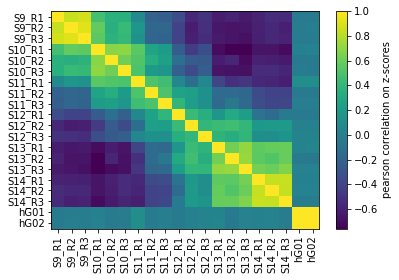

In [264]:
plt.imshow(cmzdf, aspect = 'auto')
plt.xticks(range(len(cmzdf.columns)), cmzdf.columns, rotation = 90)
plt.yticks(range(len(cmzdf.columns)), cmzdf.columns)
plt.colorbar(label = 'pearson correlation on z-scores')
plt.savefig('heatmap-correlation-zscoremicroarrah-scaledzscoregastruloid.pdf', bbox_inches = 'tight')
plt.show()

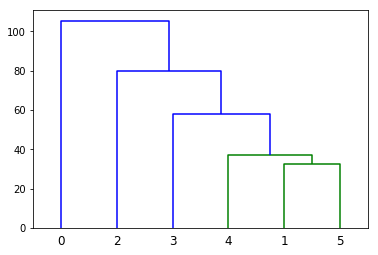

In [211]:
clSample = comboCluster(mzdf.loc[genes_common].T, mzdf.columns, seed = 126139, gridheight=2, gridwidth=3, cth = 50, nolabels=False)

In [212]:
clSample

,som,hcl
S9_R1,0,1
S9_R2,0,1
S9_R3,0,1
S10_R1,3,1
S10_R2,3,1
S10_R3,3,1
S11_R1,4,0
S11_R2,4,0
S11_R3,4,0
S12_R1,5,0


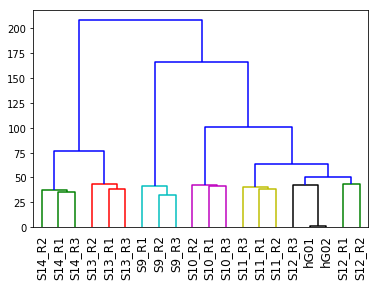

In [272]:
Zsample = linkage(mzdf.loc[genes_common].T, method='ward', metric = 'euclidean')
dgsample = dendrogram(Zsample, no_labels=False, labels=mzdf.columns, color_threshold=50, no_plot = False, leaf_rotation = 90)
plt.savefig('hcluster-zscore-dendrogram.pdf', bbox_inches = 'tight')
plt.show()

In [273]:
! open hcluster-zscore-dendrogram.pdf

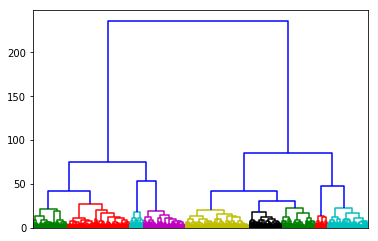

In [260]:
Zgenes = linkage(mzdf.loc[genes_common], method='ward', metric = 'euclidean')
dggenes = dendrogram(Zgenes, no_labels=True, color_threshold=30, no_plot = False)
plt.show()

In [261]:
cdgsample = getClusterByColor(dgsample, mzdf.columns)
cdggenes = getClusterByColor(dggenes, genes_common)

In [262]:
cdgsampledf = pd.Series({g: hcl for hcl in cdgsample for g in cdgsample[hcl]})
cdggenesdf = pd.Series({g: hcl for hcl in cdggenes for g in cdggenes[hcl]})

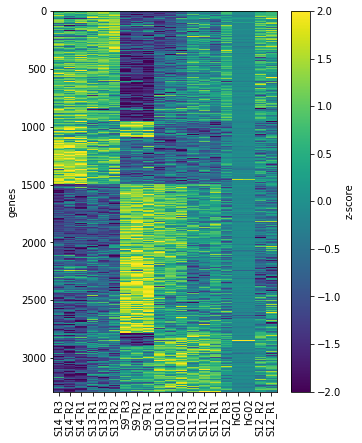

In [276]:
plt.figure(figsize=(5,7))
gene_order = cdggenesdf.sort_values().index
sample_order = cdgsampledf.sort_values().index
plt.imshow(mzdf.loc[gene_order, sample_order], aspect = 'auto', vmin = -2, vmax = 2)
plt.xticks(range(len(sample_order)), sample_order, rotation = 90)
plt.colorbar(label = 'z-score')
plt.ylabel('genes')
plt.savefig('heatmap-zscore-pooled.pdf', bbox_inches = 'tight')
plt.show()